In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [2]:
train_df = pd.read_excel("data/train.xlsx")
test1_df = pd.read_excel("data/testA.xlsx")
test2_df = pd.read_excel("data/testB.xlsx")

In [3]:
train_y = train_df[train_df.columns[-1]]
train_y.shape
new_column = test1_df.columns
train_df = train_df[new_column]
train_id = train_df['ID']
test1_id = test1_df['ID']
test2_id = test2_df['ID']
train_df.drop(['ID'], axis=1, inplace=True)
test1_df.drop(['ID'], axis=1, inplace=True)
test2_df.drop(['ID'], axis=1, inplace=True)

In [4]:
train_df = train_df[train_y>1.8]
train_df.shape

(799, 5952)

In [5]:
train_y = train_y[train_y>1.8]
train_y.shape

(799,)

In [6]:
# get int and time part first
ints = []
year = []
names = train_df.columns
dts = train_df.dtypes
for i in range(len(names)):
    if 'int' in str(dts[i]) or 'object' in str(dts[i]):
        ints.append(names[i])
print(len(ints))

for n in ints:
    if str(train_df[n][0])[:4] == '2017' and str(test1_df[n][0])[:4] == '2017':
        year.append(n)
print(len(year))

770
45


In [7]:
# whether these has nulls
df_X = pd.concat([train_df, test1_df, test2_df], axis=0)
print(df_X.shape)
print(np.sum(df_X[year].isnull().values))
print(np.sum(df_X[ints].isnull().values))

(1511, 5952)
621
32239


In [8]:
count = 0
for n in year:
    x = np.sum(np.sum(df_X[n].isnull().values))
    x1 = np.sum(np.sum(train_df[n].isnull().values))
    x2 = np.sum(np.sum(test1_df[n].isnull().values))
    x3 = np.sum(np.sum(test2_df[n].isnull().values))
    if x > 0:
        count += 1
        print(n, x, x1, x2, x3)
print(count)

330X640 124 0 78 46
330X641 124 0 78 46
330X1165 124 0 78 46
330X1168 124 0 78 46
330X1169 124 0 78 46
520X148 1 0 0 1
6


In [9]:
# manipulate year first
dfx_year = df_X[year]
# fix null
for n in year:
    x = np.sum(np.sum(df_X[n].isnull().values))
    if x > 0:
        c = dfx_year[n]
        r = c[c.notnull()]
        dfx_year[n][c.isnull()] = np.mean(r)
print(np.sum(dfx_year.isnull().values))

/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/magnusterra/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_n

0


In [10]:
year_n = dfx_year.columns
standardlen = len(str(dfx_year[year_n[0]][0]))
for i in range(1, len(year_n)):
    l = len(str(dfx_year[year_n[i]][0]))
    bias = standardlen - l
    b10 = 1
    if bias > 0:
        for j in range(bias):
            b10 *= 10
            #dfx_year[year_n[i]] /= 10
    elif bias < 0:
        for j in range(-bias):
            b10 /= 10
            #dfx_year[year_n[i]] *= 10
    if b10 != 1:
        dfx_year[year_n[i]] *= b10
    dfx_year[year_n[i]] = dfx_year[year_n[i]] - dfx_year[year_n[0]] 

/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
dfx_time = (dfx_year - np.mean(dfx_year))/np.std(dfx_year)

In [12]:
dfx_time = dfx_time[dfx_time.columns[1:]]
dfx_time.shape

(1511, 44)

In [13]:
# then manipulate the one_hots
count = 0
print(len(ints)-len(year))
drop_ints = []
for n in ints:
    if n not in year:
        x = np.sum(df_X[n].isnull().values)
        if x > 0:
            x1 = np.sum(train_df[n].isnull().values)/799
            x2 = np.sum(test1_df[n].isnull().values)/300
            x3 = np.sum(test2_df[n].isnull().values)/412
            x4 = len(df_X[n].unique())
            if x2 > 0.4 or x3 > 0.4 or x4 > 10:
                drop_ints.append(n)
            print(n, x1, x2, x3, x4)
            count += 1
print(count, len(drop_ints))

725
220X158 0.0 0.833333333333 1.0 2
220X199 0.0 0.833333333333 1.0 2
220X205 0.0 0.833333333333 1.0 2
220X220 0.0 0.833333333333 1.0 2
220X222 0.0 0.833333333333 1.0 2
220X223 0.0 0.833333333333 1.0 29
220X224 0.0 0.833333333333 1.0 220
312X36 0.0 0.04 0.0 5
312X46 0.0 0.04 0.0 6
312X51 0.0 0.04 0.0 59
312X57 0.0 0.04 0.0 104
312X63 0.0 0.04 0.0 81
312X87 0.0 0.04 0.0 10
312X93 0.0 0.04 0.0 6
312X99 0.0 0.04 0.0 4
312X105 0.0 0.04 0.0 3
312X147 0.0 0.04 0.0 3
312X153 0.0 0.04 0.0 4
312X177 0.0 0.04 0.0 3
312X253 0.0 0.04 0.0 10
312X259 0.0 0.04 0.0 38
312X265 0.0 0.04 0.0 10
312X271 0.0 0.04 0.0 2
312X277 0.0 0.04 0.0 8
312X283 0.0 0.04 0.0 5
312X289 0.0 0.04 0.0 5
312X295 0.0 0.04 0.0 3
312X301 0.0 0.04 0.0 2
312X307 0.0 0.04 0.0 3
312X313 0.0 0.04 0.0 2
312X319 0.0 0.04 0.0 2
312X325 0.0 0.04 0.0 2
312X331 0.0 0.04 0.0 5
312X337 0.0 0.04 0.0 5
312X343 0.0 0.04 0.0 2
312X349 0.0 0.04 0.0 5
312X355 0.0 0.04 0.0 4
312X361 0.0 0.04 0.0 5
312X367 0.0 0.04 0.0 3
312X373 0.0 0.04 0.0 9
312

In [14]:
newints = set(ints) - set(year) - set(drop_ints)
print(len(newints))

639


In [15]:
count = 0
nullints = []
for n in newints:
    c = df_X[n]
    x = np.sum(c.isnull().values)
    if x > 0:
        nullints.append(n)
        r = c[c.notnull()]
        count += 1
print(count)

131


In [16]:
# not fix the null first, just drop it
nints = set(newints) - set(nullints)
print(len(nints))

508


In [17]:
remains1 = []
remains2 = []
tobedrop = []

for n in nints:
    lu1 = len(train_df[n].unique())
    lu2 = len(df_X[n].unique())
    if lu1 < 10 and lu1 > 1:
        remains1.append(n)
    if lu2 < 10 and lu2 > 1:
        remains2.append(n)
    if lu1 != lu2:
        tobedrop.append(n)
    
print(len(remains1), len(remains2), len(tobedrop), len(year))

120 129 145 45


In [18]:
toberemain = list(set(remains1) & set(remains2) - set(tobedrop))
print(len(toberemain))

84


In [19]:
def dict2list(dic:dict):
    ''' 将字典转化为列表 '''
    keys = dic.keys()
    vals = dic.values()
    lst = [(key, val) for key, val in zip(keys, vals)]
    return lst

def LastRemainJudge(column):
    unique = set(column)
    uf = {}
    for u in unique:
        uf[u] = 0
    for c in column:
        uf[c] += 1
    sl = sorted(dict2list(uf), key = lambda x:x[1], reverse=True)
    x = sl[0][1]/len(column)
    sl = np.array(sl)
    if x < 0.8:
        #print(sl[:, 1]/len(column))
        return True
    else:
        return False

In [20]:
lm1 = []
lm2 = []
for n in toberemain:
    if LastRemainJudge(train_df[n]):
        lm1.append(n)
    if LastRemainJudge(df_X[n]):
        lm2.append(n)
print(len(lm1), len(lm2), len(set(lm1)&set(lm2)))

53 52 52


In [21]:
dfx_onehot_n = list(set(lm1) & set(lm2))
print(len(dfx_onehot_n))

52


In [22]:
dfx_onehot = df_X[dfx_onehot_n]

In [23]:
ohnames = dfx_onehot.columns
for i in range(len(ohnames)):
    n = ohnames[i]
    tmp = pd.get_dummies(dfx_onehot[n], prefix='onehot_'+str(i))
    dfx_onehot = pd.concat([dfx_onehot, tmp], axis=1)

dfx_onehot.drop(ohnames, axis=1, inplace=True)
print(dfx_onehot.shape)

(1511, 200)


In [313]:
# manipulate the global part of float manipulation
names = df_X.columns
dtypes = df_X.dtypes
floats = []
for i in range(len(names)):
    n = names[i]
    d = dtypes[i]
    if 'float' in str(d):
        floats.append(n)
print(len(floats))

5423


In [314]:
dfxF = df_X[floats]
drop_names = []
for n in dfxF.columns:
    c = dfxF[n]
    r = c[c.notnull()]
    tmps = np.std(r)
    if tmps == 0:
        drop_names.append(n)
dnl = len(drop_names)
print(dnl)
if dnl > 0:
    dfxF.drop(drop_names, axis=1, inplace=True)
print(dfxF.shape)

475
(1511, 4948)


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [315]:
drop_names = []
names = dfxF.columns
for n in names:
    x = np.sum(dfxF[n].isnull())
    if x > 700:
        drop_names.append(n)
print(len(drop_names))
dnl = len(drop_names)
print(dnl)
if dnl > 0:
    dfxF.drop(drop_names, axis=1, inplace=True)
print(dfxF.shape)

156
156
(1511, 4792)


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [316]:
means = []
stds = []
drop_names = []
names = dfxF.columns
for n in names:
    c = dfxF[n]
    r = c[c.notnull()]
    tmpm = np.mean(r)
    tmps = np.std(r)
    means.append(tmpm)
    stds.append(tmps)
    if tmps == 0:
        drop_names.append(n)
print(len(set(means)), len(set(stds)))
print(len(drop_names))

2556 2540
0


In [317]:
dfxF.shape

(1511, 4792)

In [318]:
names = dfxF.columns
added = set()
sames = []
for i in range(len(names)):
    tmpsl = []
    tmpsl.append(i)
    for j in range(i+1, len(names)):
        if means[i] == means[j] and stds[i] == stds[j]:
            c1 = dfxF[names[i]]
            c2 = dfxF[names[j]]
            x1 = np.sum(c1.isnull())
            x2 = np.sum(c2.isnull())
            if x1 == x2:
                if x1 == 0:
                    if np.sum(c1==c2) >1500:
                        if i not in added:
                            added.add(i)
                        if j not in added:
                            added.add(j)
                            tmpsl.append(j)
                else:
                    if np.sum(c1.isnull()==c2.isnull()) > 1500:
                        r1 = c1[c1.isnull()]
                        r2 = c2[c2.isnull()]
                        if np.sum(r1==r2) == 1511-x1:
                            if i not in added:
                                added.add(i)
                            if j not in added:
                                added.add(j)
                                tmpsl.append(j)
    if len(tmpsl) > 1:
        sames.append(tmpsl)
print(len(sames))

277


In [319]:
names = dfxF.columns
drop_names = []
for i in sames:
    for j in i[1:]:
        drop_names.append(names[j])
print(len(drop_names))

1642


In [320]:
dfxF.drop(drop_names, axis=1, inplace=True)
print(dfxF.shape)

(1511, 3150)


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [321]:
t_null = []
e_null = []
drop_names = []
for n in dfxF.columns:
    c = dfxF[n]
    x = np.sum(c.isnull())
    if x > 0:
        xt = np.sum(c[:799].isnull())
        xe = np.sum(c[799:1099].isnull())
        t_null.append(xt)
        e_null.append(xe)
        drop_names.append(n)
print(len(t_null), len(drop_names))

2242 2242


In [322]:
t_null = np.array(t_null)
e_null = np.array(e_null)
drop_names = np.array(drop_names)
remain_names = copy.copy(drop_names)
t_null_1 = t_null[e_null<70]
e_null_1 = e_null[e_null<70]
remain_names = remain_names[e_null<70]
print("after first drop", len(t_null_1))
t_null_2 = t_null_1[t_null_1<80]
e_null_2 = e_null_1[t_null_1<80]
remain_names = remain_names[t_null_1<80]
print("after second drop", len(t_null_2), len(remain_names))
drop_names = list(set(drop_names)-set(remain_names))
print(len(drop_names))

after first drop 1258
after second drop 1246 1246
996


In [323]:
print(np.sum(e_null_2>70))

0


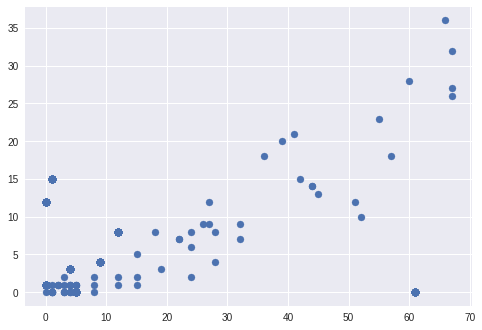

In [324]:
plt.scatter(t_null_2, e_null_2)
plt.show()

In [325]:
drop_names = list(set(drop_names)-set(remain_names))
print(len(drop_names))

996


In [326]:
dfxF.drop(drop_names, axis=1, inplace=True)
print(dfxF.shape)

(1511, 2154)


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [327]:
t_null = []
e_null = []
drop_names = []
for n in dfxF.columns:
    c = dfxF[n]
    x = np.sum(c.isnull())
    if x > 0:
        xt = np.sum(c[:799].isnull())/799
        xe = np.sum(c[799:1099].isnull())/300
        t_null.append(xt)
        e_null.append(xe)
        drop_names.append(n)
print(len(t_null), len(drop_names))

1246 1246


In [328]:
remain_names = copy.copy(drop_names)

In [329]:
tnr = []
enr = []
for i in range(len(t_null)):
    tmpt = t_null[i]
    tmpe = e_null[i]
    if tmpt > 0 and tmpe > 0:
        tnr.append(tmpt/tmpe)
        enr.append(tmpe/tmpt)
    else:
        tnr.append(0)
        enr.append(0)
tnr = np.array(tnr)
enr = np.array(enr)
print(len(tnr), len(enr))

1246 1246


In [330]:
drop_names = np.array(drop_names)
remain_names = np.array(remain_names)
tnr_1 = tnr[enr<5]
enr_1 = enr[enr<5]
remain_names = remain_names[enr<5]
tnr_2 = tnr_1[tnr_1<3]
enr_2 = enr_1[tnr_1<3]
remain_names = remain_names[tnr_1<3]
print(len(tnr_2), len(remain_names))
drop_names = list(set(drop_names)-set(remain_names))
print(len(drop_names))

945 945
301


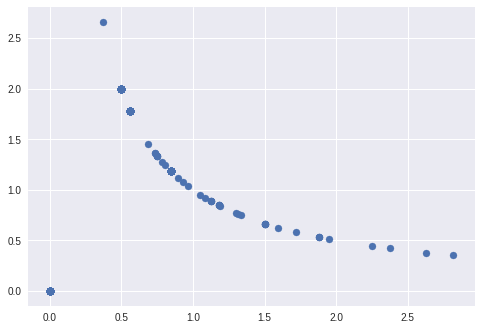

In [331]:
plt.scatter(tnr_2, enr_2)
plt.show()

In [332]:
dfxF.drop(drop_names, axis=1, inplace=True)
print(dfxF.shape)

(1511, 1853)


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [334]:
# fix the dfxs by mean of each
print(dfxF.shape)
for n in dfxF.columns:
    c = dfxF[n]
    x = np.sum(c.isnull())
    if x > 0:
        c1 = c[:799]
        c2 = c[799:1099]
        c3 = c[1099:]
        dfxF[n][:799][c1.isnull()] = np.mean(np.mean(c1[c1.notnull()]))
        dfxF[n][799:1099][c2.isnull()] = np.mean(np.mean(c2[c2.notnull()]))
        dfxF[n][1099:][c3.isnull()] = np.mean(np.mean(c3[c3.notnull()]))
print(np.sum(dfxF.isnull().values))

(1511, 1853)
0


In [335]:
meansftr = np.mean(dfxF[:799])
stdsftr = np.std(dfxF[:799])
meansfte1 = np.mean(dfxF[799:1099])
stdsfte1 = np.std(dfxF[799:1099])

In [342]:
names1 = dfxF.columns
m_ratio_r = np.abs((meansftr-meansfte1)/meansfte1)
s_ratio_r = np.abs((stdsftr-stdsfte1)/stdsfte1)
print(len(names1), len(m_ratio_r))
names1 = names1[s_ratio_r<1.25]
m_ratio_r = m_ratio_r[s_ratio_r<1.25]
s_ratio_r = s_ratio_r[s_ratio_r<1.25]
names1 = names1[m_ratio_r<6]
s_ratio_r = s_ratio_r[m_ratio_r<6]
m_ratio_r = m_ratio_r[m_ratio_r<6]
print(len(s_ratio_r), len(names1))

1853 1853
1748 1748


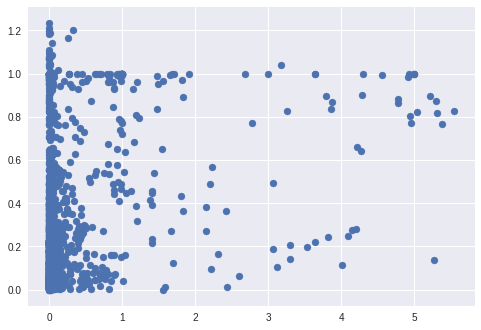

In [343]:
plt.scatter(m_ratio_r, s_ratio_r)
plt.show()

In [384]:
names2 = dfxF.columns
m_ratio_e = np.abs((meansftr-meansfte1)/meansftr)
s_ratio_e = np.abs((stdsftr-stdsfte1)/stdsftr)
names2 = names2[s_ratio_e<2.25]
m_ratio_e = m_ratio_e[s_ratio_e<2.25]
s_ratio_e = s_ratio_e[s_ratio_e<2.25]
names2 = names2[m_ratio_e<3]
s_ratio_e = s_ratio_e[m_ratio_e<3]
m_ratio_e = m_ratio_e[m_ratio_e<3]
print(len(s_ratio_e), len(names2))

1669 1669


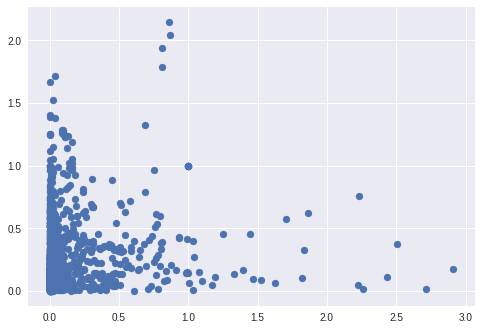

In [385]:
plt.scatter(m_ratio_e, s_ratio_e)
plt.show()

In [386]:
print(len(set(names1) & set(names2)))

1566


In [387]:
nxf = dfxF[list(set(names1) & set(names2))]
print(nxf.shape)
corr_values = []
float_col = nxf.columns
float_df = nxf[:799]
for col in float_col:
    corr_values.append(abs(np.corrcoef(float_df[col].values,train_y)[0,1]))
corr_df = pd.DataFrame({'col':float_col,'corr_value':corr_values})
corr_df = corr_df.sort_values(by='corr_value',ascending=False)

(1511, 1566)


In [397]:
np.sum(corr_df>0.005)

col           1566
corr_value    1524
dtype: int64

In [398]:
# now it's the turn of floats
def floatFirstStep(ratio, co):
    names = nxf.columns
    drop_names = []
    #ratio = 0.1
    for i in range(len(names)):
        n = names[i]
        trd = train_df[n]
        ted = test1_df[n]
        
        misstr = np.sum(trd.isnull())/799
        misste = np.sum(ted.isnull())/300
        if np.abs(misstr-misste) > ratio:
            drop_names.append(n)
        else:
            trrd = trd[trd.notnull()]
            terd = ted[ted.notnull()]
            m1 = np.mean(trrd)
            s1 = np.std(trrd)
            m2 = np.mean(terd)
            s2 = np.std(terd)
            if co == 'm':
                if np.abs(m1-m2)>ratio*np.abs(m1) and np.abs(s1-s2)>ratio*np.abs(s1):
                    drop_names.append(n)
            elif co == 's':
                if np.abs(m1-m2)>ratio*np.abs(s1) and np.abs(s1-s2)>ratio*np.abs(s1):
                    drop_names.append(n)
            if s1 == 0 or s2 == 0:
                drop_names.append(n)
    #print(len(drop_names), len(floats))
    return list(set(names) - set(drop_names))

def FloatDrop(dfx_float_n):
    dfx_float = nxf[dfx_float_n]
    drop_names = []
    names = dfx_float.columns
    for n in names:
        x = np.sum(dfx_float[n].isnull())
        if x > 700:
            drop_names.append(n)
    #print(len(drop_names))
    if len(drop_names) > 0:
        dfx_float.drop(drop_names, axis=1, inplace=True)
    
    means = []
    stds = []
    drop_names = []
    names = dfx_float.columns
    for n in names:
        c = dfx_float[n]
        r = c[c.notnull()]
        tmpm = np.mean(r)
        tmps = np.std(r)
        means.append(tmpm)
        stds.append(tmps)
        if tmps == 0:
            drop_names.append(n)
    #print(len(set(means)), len(set(stds)))
    #print(len(drop_names))
    if len(drop_names) > 0:
        dfx_float.drop(drop_names, axis=1, inplace=True)
    
    names = dfx_float.columns
    added = set()
    sames = []
    for i in range(len(names)):
        tmpsl = []
        tmpsl.append(i)
        for j in range(i+1, len(names)):
            if means[i] == means[j] and stds[i] == stds[j]:
                if i not in added:
                    added.add(i)
                if j not in added:
                    added.add(j)
                    tmpsl.append(j)
        if len(tmpsl) > 1:
            sames.append(tmpsl)
    #print(len(sames))
    names = dfx_float.columns
    drop_names = []
    for i in sames:
        for j in i[1:]:
            drop_names.append(names[j])
    #print(len(drop_names))
    if len(drop_names) > 0:
        dfx_float.drop(drop_names, axis=1, inplace=True)
    
    names = dfx_float.columns
    for n in names:
        c = dfx_float[n]
        r = c[c.notnull()]
        tmpm = np.mean(r)
        tmps = np.std(r)
        assert tmps>0
        dfx_float[n][c.isnull()] = tmpm
    return dfx_float

def Float2Log(dfx_float, mlt_ratio):
    mid = dfx_float-np.min(dfx_float)
    dfx_log1p = np.log1p(mid*mlt_ratio+1)
    ret = (dfx_log1p - np.mean(dfx_log1p))/np.std(dfx_log1p)
    return ret

In [421]:
nxf2 = Float2Log(nxf, 1)
print(nxf2.shape)

(1511, 1566)


In [41]:
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance

/home/magnusterra/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [42]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [43]:
def MSE(y_raw, y_pred):
    r = np.mean(np.square(y_raw-y_pred))
    #print(r)
    return r

In [44]:
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV 

/home/magnusterra/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [422]:
param_co = ['m', 's']
param_ratio = [0.1, 0.2, 0.3, 0.5, 0.75, 1, 2, 3, 5]
#param_mlt = [1e-2, 1e-1, 1, 10, 100, 1000]
for r in param_ratio:
    for c in param_co:
        #fns = floatFirstStep(r, c)
        dfx_float = copy.copy(nxf)
        dfx_log1p = Float2Log(dfx_float, 1)
        ndfx = pd.concat([dfx_float, dfx_onehot, dfx_time], axis=1)
        print(c, r, m, 'data over, validate', ndfx.shape)
        results = []
        for i in range(100):
            subxtrain, subxval, subytrain, subyval = train_test_split(ndfx[:799].values, train_y.values, test_size=0.3, random_state=i)

            xgb = XGBRegressor()
            xgb.fit(subxtrain, subytrain)
            test1_pred = xgb.predict(subxval)
            t = MSE(test1_pred, subyval)
            results.append(t)
        print(np.mean(results), np.std(results), np.max(results), np.min(results))

m 0.1 1000 data over, validate (1511, 1810)


KeyboardInterrupt: 

In [423]:
usesx = pd.concat([nxf2, dfx_onehot, dfx_time], axis=1)
print(usesx.shape)

(1511, 1810)


In [403]:
tuned_parameters = {'objective':['reg:linear'], 'max_depth':[1,2,3,4],
                    'gamma':[0, 1e-5, 1e-4, 1e-3,  1e-2, 1e-1], 'subsample':[0.85, 0.7]}
for i in range(100):
    subxtrain, subxval, subytrain, subyval = train_test_split(usesx[:799].values, train_y.values, test_size=0.3, random_state=i)
    
    clf = GridSearchCV(estimator =XGBRegressor(), param_grid =tuned_parameters, cv=5, scoring='neg_mean_squared_error')
    clf.fit(subxtrain, subytrain)
    print(i)
    print(clf.best_params_)  
    y_pred1 = clf.predict(subxtrain)
    mse1 = MSE(y_pred1, subytrain)
    y_pred2 = clf.predict(subxval)
    mse2 = MSE(subyval, y_pred2)
    print(mse1, mse2)
print("----------------------------------")
clf = GridSearchCV(estimator =XGBRegressor(), param_grid =tuned_parameters, cv=5, scoring='neg_mean_squared_error')
clf.fit(usesx[:799].values, train_y.values)
print(clf.best_params_)  
y_pred1 = clf.predict(usesx[:799].values)
print(MSE(y_pred1, train_y.values))

0
{'gamma': 0.0001, 'max_depth': 4, 'objective': 'reg:linear', 'subsample': 0.85}
0.000683865186766 0.013442819594
1
{'gamma': 0.001, 'max_depth': 4, 'objective': 'reg:linear', 'subsample': 0.85}
0.000493228703024 0.0179758194218
2
{'gamma': 0, 'max_depth': 3, 'objective': 'reg:linear', 'subsample': 0.7}
0.00215747526725 0.0154803043613
3
{'gamma': 0.0001, 'max_depth': 3, 'objective': 'reg:linear', 'subsample': 0.85}
0.00203557423178 0.0140773436045
4
{'gamma': 0.01, 'max_depth': 4, 'objective': 'reg:linear', 'subsample': 0.85}
0.000828912393687 0.0159163377031
5
{'gamma': 0.01, 'max_depth': 2, 'objective': 'reg:linear', 'subsample': 0.85}
0.00562853303183 0.0143593724998
6
{'gamma': 0.0001, 'max_depth': 3, 'objective': 'reg:linear', 'subsample': 0.7}
0.00190879426302 0.0150192062193
7
{'gamma': 0.01, 'max_depth': 4, 'objective': 'reg:linear', 'subsample': 0.7}
0.000903603973471 0.0151639520465
8
{'gamma': 0.001, 'max_depth': 3, 'objective': 'reg:linear', 'subsample': 0.85}
0.002199124

72
{'gamma': 0.001, 'max_depth': 3, 'objective': 'reg:linear', 'subsample': 0.7}
0.00198981957344 0.0140268718975
73
{'gamma': 0.01, 'max_depth': 3, 'objective': 'reg:linear', 'subsample': 0.85}
0.0021077283393 0.0156840049856
74
{'gamma': 0, 'max_depth': 3, 'objective': 'reg:linear', 'subsample': 0.85}
0.00221243666214 0.0143946945709
75
{'gamma': 0.0001, 'max_depth': 4, 'objective': 'reg:linear', 'subsample': 0.7}
0.00060306174509 0.0152223397171
76
{'gamma': 0.001, 'max_depth': 3, 'objective': 'reg:linear', 'subsample': 0.85}
0.00216328441887 0.0141322550713
77
{'gamma': 0.001, 'max_depth': 4, 'objective': 'reg:linear', 'subsample': 0.85}
0.000526367281693 0.0167413528331
78
{'gamma': 0.0001, 'max_depth': 4, 'objective': 'reg:linear', 'subsample': 0.85}
0.000701372101013 0.0124562549985
79
{'gamma': 0.01, 'max_depth': 4, 'objective': 'reg:linear', 'subsample': 0.85}
0.000931653831066 0.0115364785872
80
{'gamma': 0.0001, 'max_depth': 3, 'objective': 'reg:linear', 'subsample': 0.85}
0

In [424]:
params_gamma = [1e-4, 1e-3, 1e-2]
params_subsample = [0.85, 0.7]
for g in params_gamma:
    for ss in params_subsample:
        results = []
        for i in range(100):
            subxtrain, subxval, subytrain, subyval = train_test_split(usesx[:799].values, train_y.values, test_size=0.375, random_state=i)

            xgb = XGBRegressor(objective='reg:linear', max_depth=3, gamma=g, subsample=ss)
            xgb.fit(subxtrain, subytrain)
            test1_pred = xgb.predict(subxval)
            t = MSE(test1_pred, subyval)
            results.append(t)
        print(g, ss, np.mean(results), np.std(results), np.max(results), np.min(results))

0.0001 0.85 0.0150172170567 0.00137386775051 0.0180945945427 0.0123938437704
0.0001 0.7 0.0152263028845 0.00138581795741 0.0185531904796 0.0121644055249
0.001 0.85 0.0150411473876 0.00137976538682 0.0179330451913 0.0119862508569
0.001 0.7 0.0152302984723 0.00131785307329 0.018533941926 0.0121735442756
0.01 0.85 0.0150993639632 0.00134643858945 0.0179889234864 0.011972531605
0.01 0.7 0.0151749394554 0.00129926054286 0.0181676421384 0.0124387887443


In [427]:
xgb = XGBRegressor(gamma=0.01, max_depth=3, objective='reg:linear', subsample=0.85)
xgb.fit(usesx[:799].values, train_y.values)
test1_pred = xgb.predict(usesx[:799].values)
print(MSE(test1_pred, train_y.values))
test1_pred = xgb.predict(usesx[799:1099].values)
test1_pred = test1_pred.reshape(300)
save = pd.DataFrame({'ID':test1_id, 'value':test1_pred})
save.to_csv('answer/newSynchronous_logohtime_xgb_20180122.csv', index=False, header=False)

0.0030243879559


In [416]:
names = usesx.columns

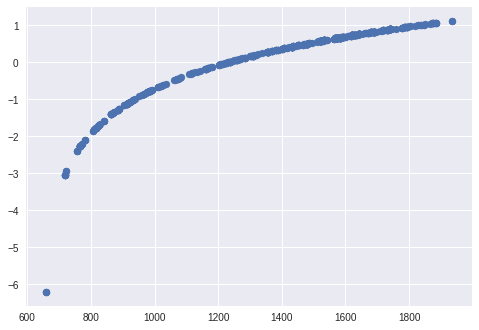

In [454]:
plt.scatter(train_df[names[300]], usesx[names[300]][:799])
plt.show()

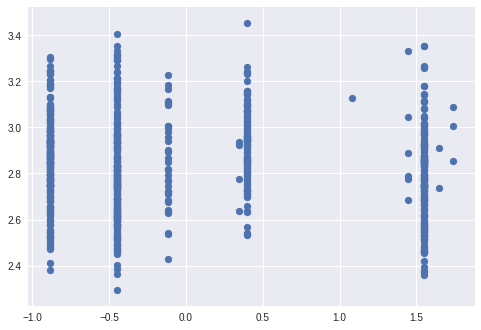

In [465]:
plt.scatter(usesx[names[9]][:799], train_y)
plt.show()